Comp 47350 - Assignment 2  
Tania Lopes  
*22202398*

# **1.0 Introduction**
<span style="color: red; font-style: italic">Refer to '22202398_Data Quality Report' for a brief introduction to the machine learning problem we would like to solve in addition to some key terminology to be familiar with. </span>

# **2.0 Data Understanding and Preparation** 

## 2.1 Prepare environment and load data
First things first, we need to import the packages that will helpus with our data analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from sklearn.impute import KNNImputer

### Define Some Functions that will help us throughout to analyze the data and regressions

In [5]:
def calculateNthMode(dataFrame, n):
    describeData = dataFrame.describe(datetime_is_numeric = True).T

    indices = describeData.index.values.tolist()

    secondMode = []
    secondModeFreq = []
    
    for column in dataFrame:
        secondMode.append(dataFrame[column].value_counts().index.tolist()[n-1])
        secondModeFreq.append(dataFrame[column].value_counts().tolist()[n-1])

    second_mode = pd.DataFrame(secondMode, columns=[f'{n}th mode']).set_index([indices]).T
    second_mode_freq = pd.DataFrame(secondModeFreq, columns=[f'{n}th mode freq']).set_index([indices]).T

    return second_mode, second_mode_freq


def applyToRowsAndAppend(dataFrame, expression, columnName):
    tempDataFrame_result = dataFrame.apply(expression, axis=1).rename(columnName)
    tempDataFrame = pd.concat([dataFrame, tempDataFrame_result], axis=1)
    return tempDataFrame


def getDescriptiveStatisticsForContinuousFeatures(dataFrame):
    # Get descriptive statistics, mode, second mode, and cardinality
    stats = dataFrame.describe(datetime_is_numeric = True)

    n_missing = pd.DataFrame((dataFrame.isnull()).sum(), columns=['# missing']).T
    p_missing = pd.DataFrame(((dataFrame.isnull()).sum() / dataFrame.shape[0] * 100), columns=['% missing']).T

    first_mode, first_modeFreq = calculateNthMode(dataFrame, 1)
    second_mode, second_modeFreq = calculateNthMode(dataFrame, 2)
    cardinality = pd.DataFrame(dataFrame.nunique(), columns=['cardinality']).T

    # Concatenate statistics into one descriptive statistics table
    stats = pd.concat([stats, n_missing, p_missing, first_mode, first_modeFreq, second_mode, second_modeFreq, cardinality]).T

    return stats


def getDescriptiveStatisticsForCategoricalFeatures(dataFrame):
    # Calculate the number of missing entries for each of the continuous feature
    stats = dataFrame.describe()

    n_missing = pd.DataFrame((dataFrame == 'Missing').sum(), columns=['# missing']).T
    p_missing = pd.DataFrame(((dataFrame == 'Missing').sum() / dataFrame.shape[0] * 100), columns=['% missing']).T

    # Calculate second mode
    second_mode, second_mode_frequency = calculateNthMode(dataFrame, 2)

    # Concatenate statistics into one descriptive statistics table
    stats = pd.concat([stats, n_missing, p_missing, second_mode, second_mode_frequency]).T

    return stats


def getValidityColumn(dataFrame, expression):
    validity_result = applyToRowsAndAppend(dataFrame, expression, 'Validity')
    
    # Count the number of columns where validity is not equal to True
    invalid_entry = validity_result['Validity'].value_counts().index.tolist()

    if len(invalid_entry) == 1 and invalid_entry[0]:
        print("The data passes the test.")
    else:
        count_invalid_entry = len(validity_result.loc[validity_result['Validity'] == False])
        print(f"The data does not pass the test. \n{count_invalid_entry} invalid entries.")


### Merging the datasets
<span style="color: red; font-style: italic"> write about the work done in the previous assignment to prepare a clean data set, as well as steps taken to merge the two datasets 
<br>
In a separate Jupyter Notebook (attached), the data from the two previous data sets is consolidated into one larger data set stored as one comprehensive .csv. The first step of analyzing the regressions is to load in the new data set.</span>

In [8]:
data_student_01 = pd.read_csv('data\covid19-cdc-22202398_final.csv', keep_default_na=True)
data_student_02 = pd.read_csv('data\covid19-cdc-18389156_final.csv', keep_default_na=True)

data = pd.concat([data_student_01, data_student_02], axis=0)

data.head(10)

,case_month,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,current_status,symptom_status,hosp_yn,death_yn,income,people_vaccinated,risk_factor
0,2020-11-01,32003,65+ years,Female,White,Non-Hispanic/Latino,2.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,59340,0,1
1,2021-08-01,4013,50 to 64 years,Male,White,Hispanic/Latino,3.0,0.0,Laboratory-confirmed case,Symptomatic,No,Yes,64468,206797098,1
2,2020-12-01,12101,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,52828,5566951,1
3,2020-12-01,6037,65+ years,Female,White,Non-Hispanic/Latino,2.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,68044,5566951,1
4,2020-11-01,48029,65+ years,Male,White,Hispanic/Latino,0.0,6.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,57157,0,1
5,2020-08-01,1097,65+ years,Female,White,Non-Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,47583,0,1
6,2021-09-01,16027,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,52134,215360247,1
7,2021-11-01,39133,65+ years,Female,White,Non-Hispanic/Latino,1.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,57618,233824494,1
8,2020-12-01,49035,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,No,Yes,74865,5566951,1
9,2021-01-01,12086,65+ years,Female,White,Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,51347,29890726,1



## 2.2 Splitting the data into two data sets

<span style="color: red; font-style: italic"> split the data into two datasets, 70% training and 30% test. </span>


In [9]:
from sklearn.model_selection import train_test_split

# Load the dataset into a pandas dataframe and set X and y
X = data[['case_month', 'county_fips_code', 'age_group', 'sex', 'race', 'ethnicity', 'case_positive_specimen_interval', 'case_onset_interval', 'current_status', 'symptom_status', 'hosp_yn', 'income', 'people_vaccinated', 'risk_factor' ]]
y = data['death_yn']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

data_training = pd.concat([X_train, y_train], axis=1)

## 2.3 Start working with the training set

To get a better understanding of the data we are working with, we will analyze the features in our dataset. We will achieve this by analyzing relationships between both continuous and categorical features, both among themselves and with the target feature. The first step in this process is identifying the categorical and continuous features and assigning them data types.

In [10]:
# Get continuous date features and int features separately
continuous_date = ['case_month']
continuous_int = ['case_positive_specimen_interval', 'case_onset_interval', 'income', 'people_vaccinated']

# Get aggregated continuous features
continuous = continuous_date + continuous_int

# Get categorical features
categorical = ['county_fips_code', 'age_group', 'sex', 'race', 'ethnicity', 'current_status', 'symptom_status', 'hosp_yn', 'risk_factor', 'death_yn']

# Assign types to columns - dates
for column in continuous_date:
    data_training[column] = data_training[column].astype('datetime64[ns]')

# Assign types to columns - integers
for column in continuous_int:
    data_training[column] = data_training[column].astype('Int64')

# Assign types to columns - categorical
for column in categorical:
    data_training[column] = data_training[column].astype('category')

# Print data types
data_training.dtypes

case_month                         datetime64[ns]
county_fips_code                         category
age_group                                category
sex                                      category
race                                     category
ethnicity                                category
case_positive_specimen_interval             Int64
case_onset_interval                         Int64
current_status                           category
symptom_status                           category
hosp_yn                                  category
income                                      Int64
people_vaccinated                           Int64
risk_factor                              category
death_yn                                 category
dtype: object

***
### Continuous Features
***
#### **Continuous - Continuous Plots**

<span style="color:red;"> We first get the correlation between continuous features </span>

<AxesSubplot: >

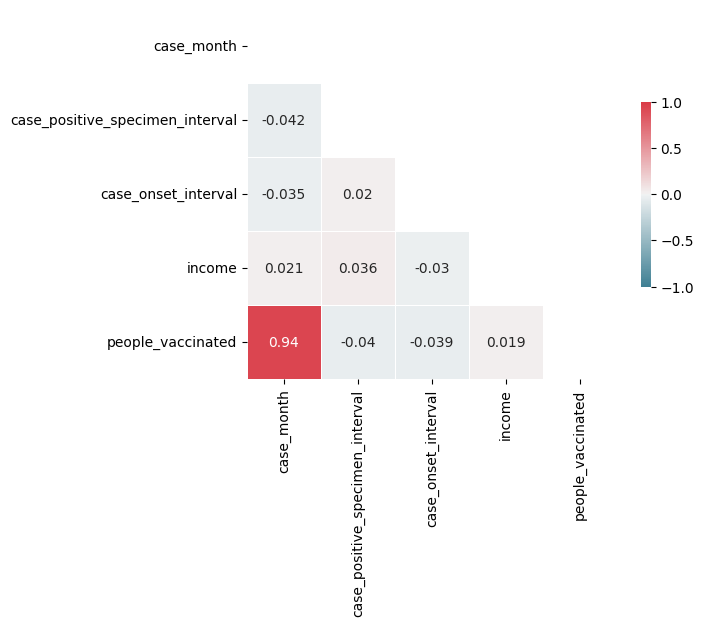

In [14]:
# Print the correlation between the continuous data types
# Specify numeric_only as False to allow us to include correlation with case_month
continuous_corr = data_training[continuous].corr(numeric_only=False)

# Generate a mask for the upper triangle
cont_mask = np.zeros_like(continuous_corr, dtype=np.bool_)
cont_mask[np.triu_indices_from(cont_mask)] = True

# Generate a custom colormap - blue and red
cont_cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(continuous_corr, annot=True, mask=cont_mask, cmap=cont_cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5})

<li style="color: blue; font-style: italic">Plot the correlations between all the continuous features (if any). Discuss what you observe in these plots.  </li>


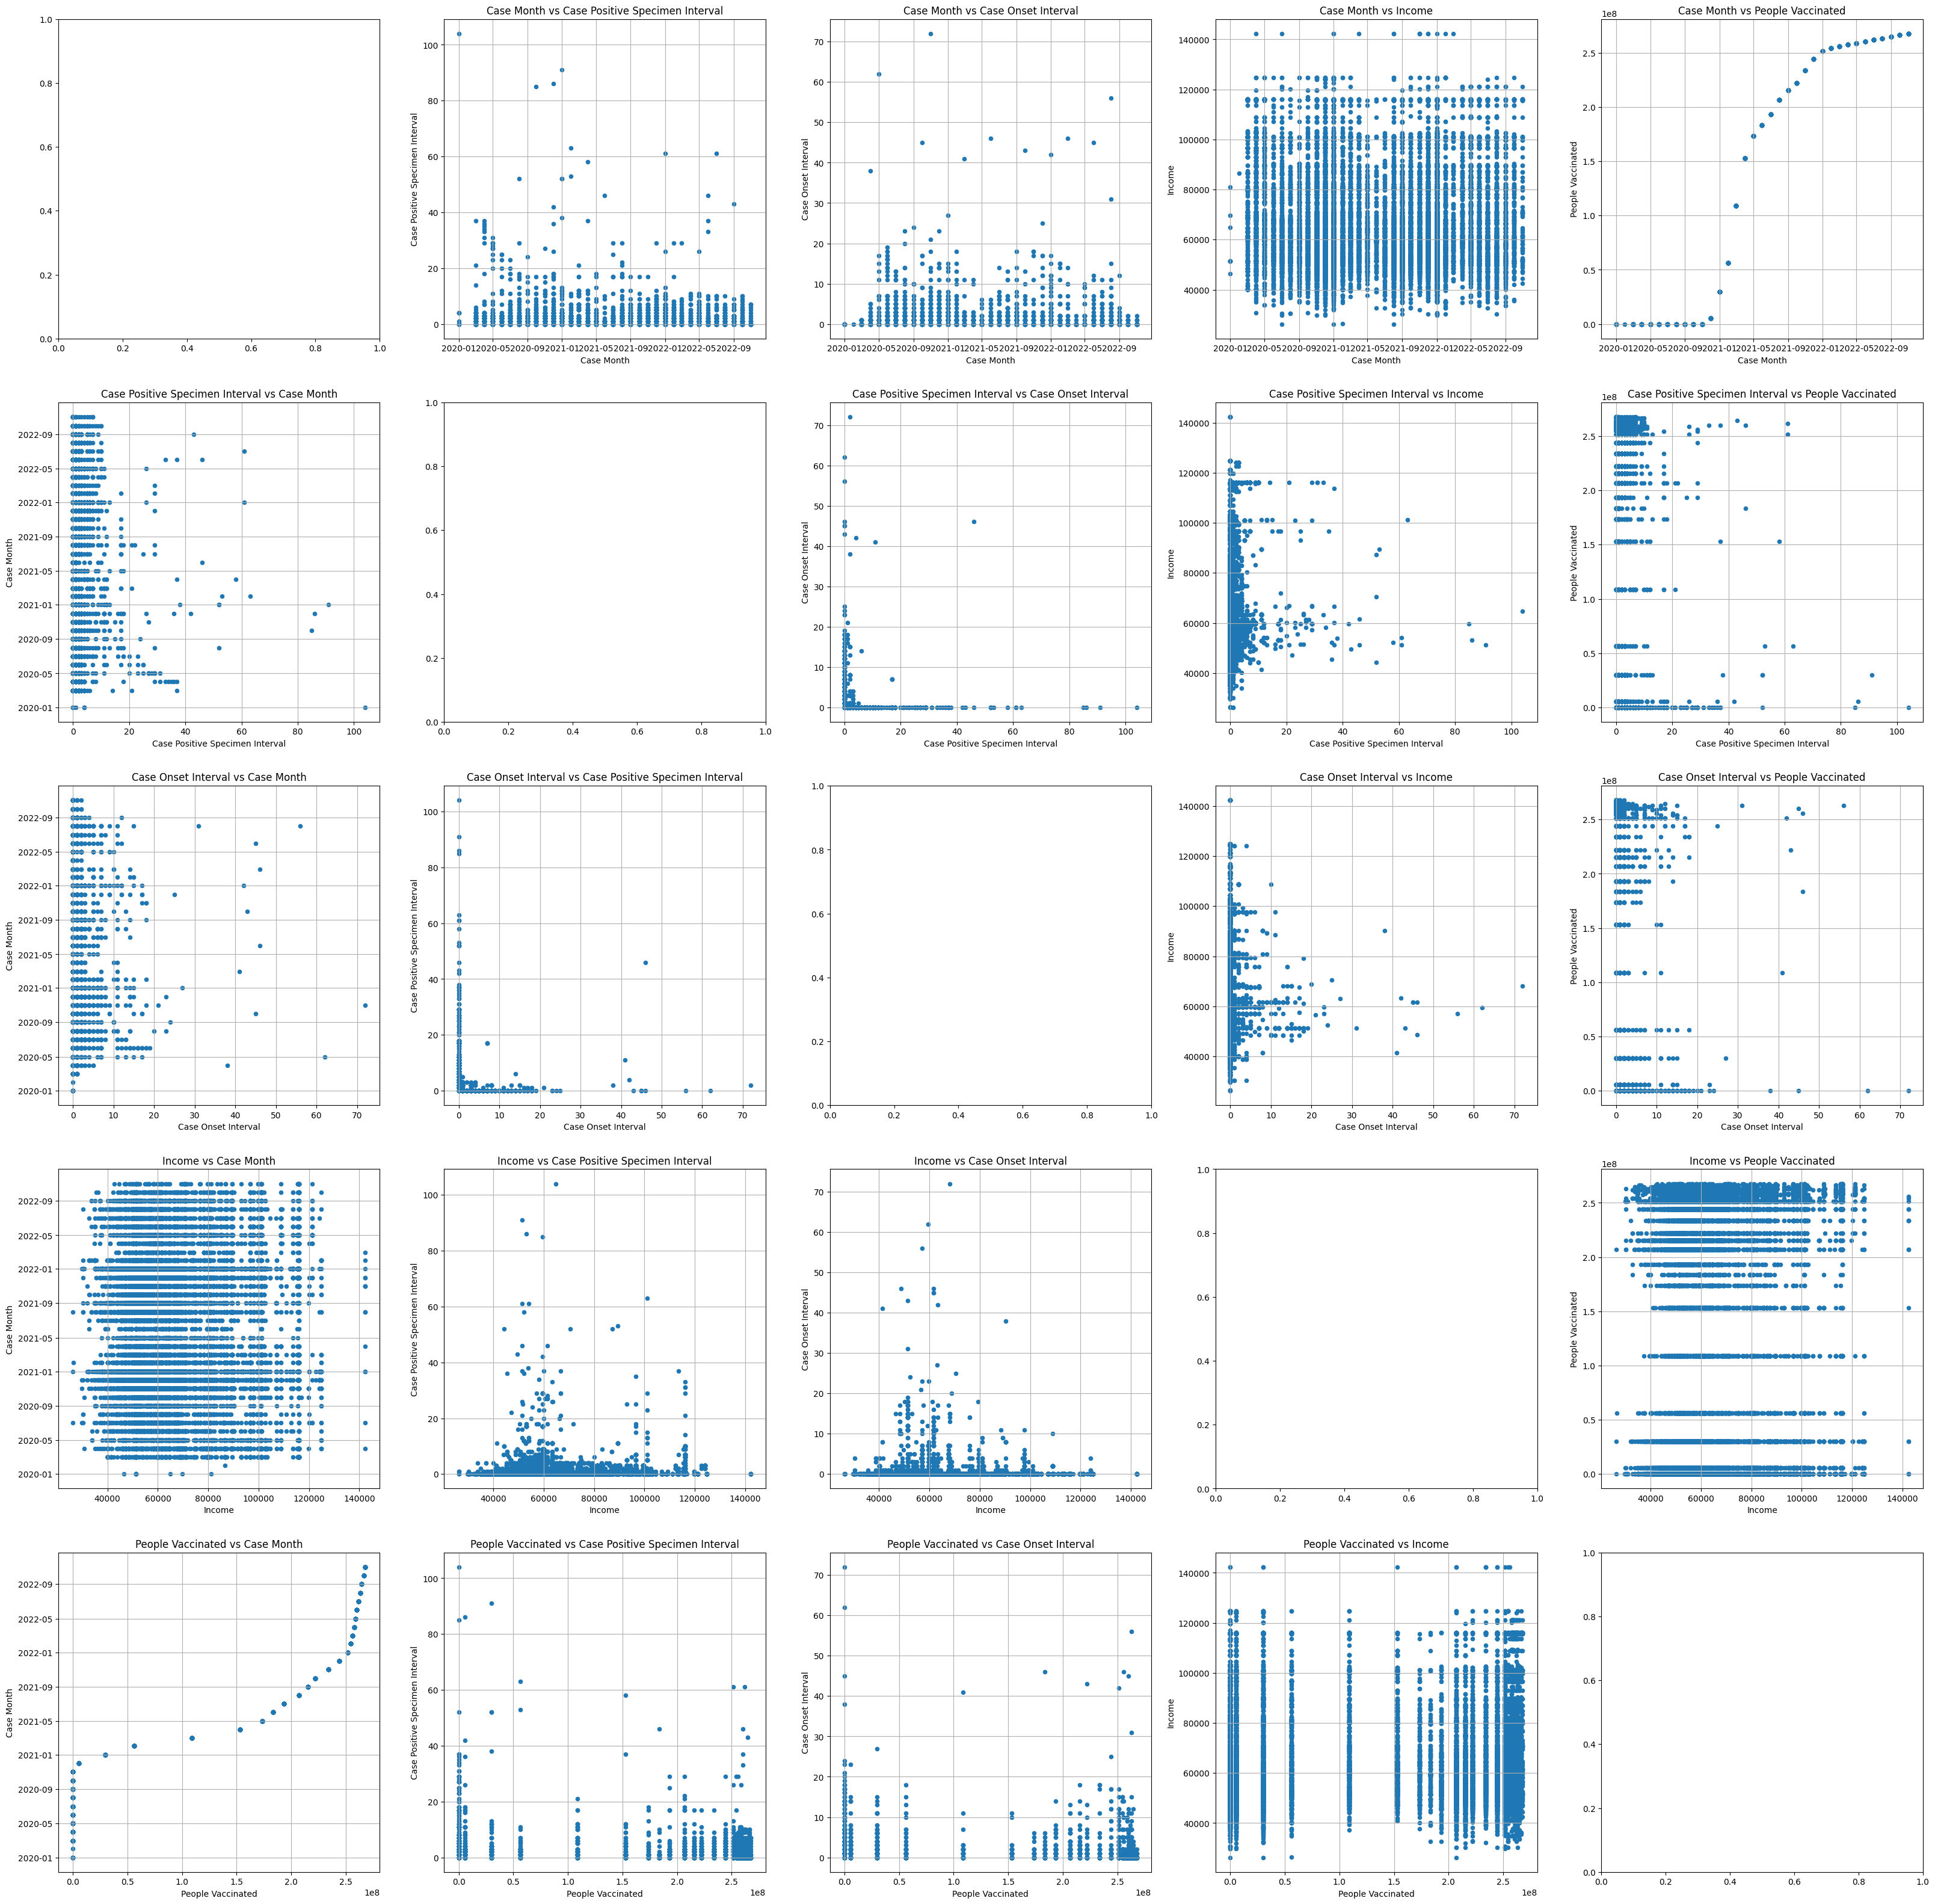

In [8]:
fig, axs = plt.subplots(ncols=5, nrows=5, figsize=(40,40))

for i, column_i in enumerate(continuous):
    for j, column_j in enumerate(continuous):
            if i != j:
                xlabel = column_i.replace("_", " ").title()
                ylabel = column_j.replace("_", " ").title()
                title = xlabel + " vs " + ylabel
                values = data_training[[column_i, column_j]]
                scatter = values.plot.scatter(x=column_i, y=column_j, ax=axs[i][j], grid=True, fontsize=10)
                scatter.set_xlabel(xlabel)
                scatter.set_ylabel(ylabel)
                scatter.set_title(title)

#### **Continuous - Target Plots**
<li style="color: blue; font-style: italic">For each continuous feature, plot its interaction with the target feature (a plot for each pair of continuous feature and target feature). Discuss what you observe from these plots, e.g., which continuous features seem to be better at predicting the target feature? </li>


In [9]:
def createStackedHistograms(data, group, to_count, bin_count=10, ax=None, i=None, j=None, filterExp=None, labelheights=None, ylim = 1):
    
    # group the data by the specified column
    data = data.dropna().copy()
    if filterExp != None:
        data = data.loc[data.apply(filterExp, axis=1)]
    if data[to_count].dtype == 'datetime64[ns]':
        data.loc[:, to_count] = (data[to_count].apply(lambda x: (x.year - data[to_count].min().year) * 12 + x.month))
    
    grouped_data = data.groupby(group)[to_count]

    values = data[to_count]
    bin_range = np.linspace(values.min(), values.max(), bin_count + 1)
    bin_width = bin_range[1]-bin_range[0]

    # Create a list of zeros to be the bottom value of each histogram bar
    bottom = 0
    bottom_value = [bottom for i in range(bin_count)]
    # Create a list of ones to be the bottom value of each histogram bar
    top = ylim
    top_value = [top for i in range(bin_count)]
    # Create a list of zeros to be a placeholder for number of bars too small to show text
    too_small_count = [0 for i in range(bin_count)]

    for name, group_data in grouped_data:
        # Get counts for histogram
        hist, _ = np.histogram(group_data, bins=bin_range)
        pct = hist / len(group_data) if len(group_data) != 0 else 0

        # Draw the histogram for the first group
        ax.bar(bin_range[:-1], pct, label=name, align='edge', width=bin_width,
               bottom=bottom_value, edgecolor='black', linewidth=0.5)
        ax.set_ylim(top=1)
        if labelheights == None:
            labelheights = (len(grouped_data) * 0.025,
                            len(grouped_data) * 0.025)

        # Count the values that will be too small to display in the center of the bar
        threshold = labelheights[0]
        if not isinstance(pct, np.ndarray):
            increment = 1 if 0 < pct < threshold else 0
            too_small_count = [tsc + increment for tsc in too_small_count]
            bottom_value = [bv + pct for bv in bottom_value]
        else:
            increment = list(map(lambda h: 1 if 0 < h < threshold else 0, pct))
            too_small_count = [tsc + i for tsc, i in zip(too_small_count, increment)]
            bottom_value += pct

        def createlabel(val):
            x = bin_range[i]+bin_width/2
            y = bottom_value[i]-val/2 + (too_small_count[i])*labelheights[1]
            text_name = textwrap.shorten(name.replace("/", " / ").replace("-"," - "), width=13, placeholder="...")
            val_text = int(round(val, 2)*100)
            ax.text(
                x=x, y=y, fontsize=6,
                s=f"{text_name}:\n {val_text}%",
                ha='center', va='center', zorder=4
            )

            rect = plt.Rectangle((x-bin_width*.9/2, y-(labelheights[1]*.8)/2),
                             width=bin_width*0.9, height=labelheights[1]*.8,
                             zorder=3, alpha=0.5, facecolor="white",
                             linewidth=0.5, edgecolor='black')
            ax.add_patch(rect)


        # Create text labels for each bar
        if not isinstance(pct, np.ndarray):
            val = pct
            if val != 0:
                createlabel(val)

        else:
            for i, val in enumerate(pct):
                if val != 0:
                    createlabel(val)
        
        ax.set_xticks(bin_range)
        ax.grid(axis='y', alpha=0.5, color='lightgrey', linestyle='--')
        ax.set_yticks(np.linspace(bottom, top, 11))


        # Axis labels
        ax.set_xlabel(str(to_count).title().replace("_", " "), labelpad=20)
        ax.set_ylabel(f'Frequency of {group.replace("_", " ").title()}', labelpad=20)

        title = f'{to_count} by {group}'.replace("_", " ").title()
        ax.set_title(title, fontsize=18, pad=20)
        ax.legend()

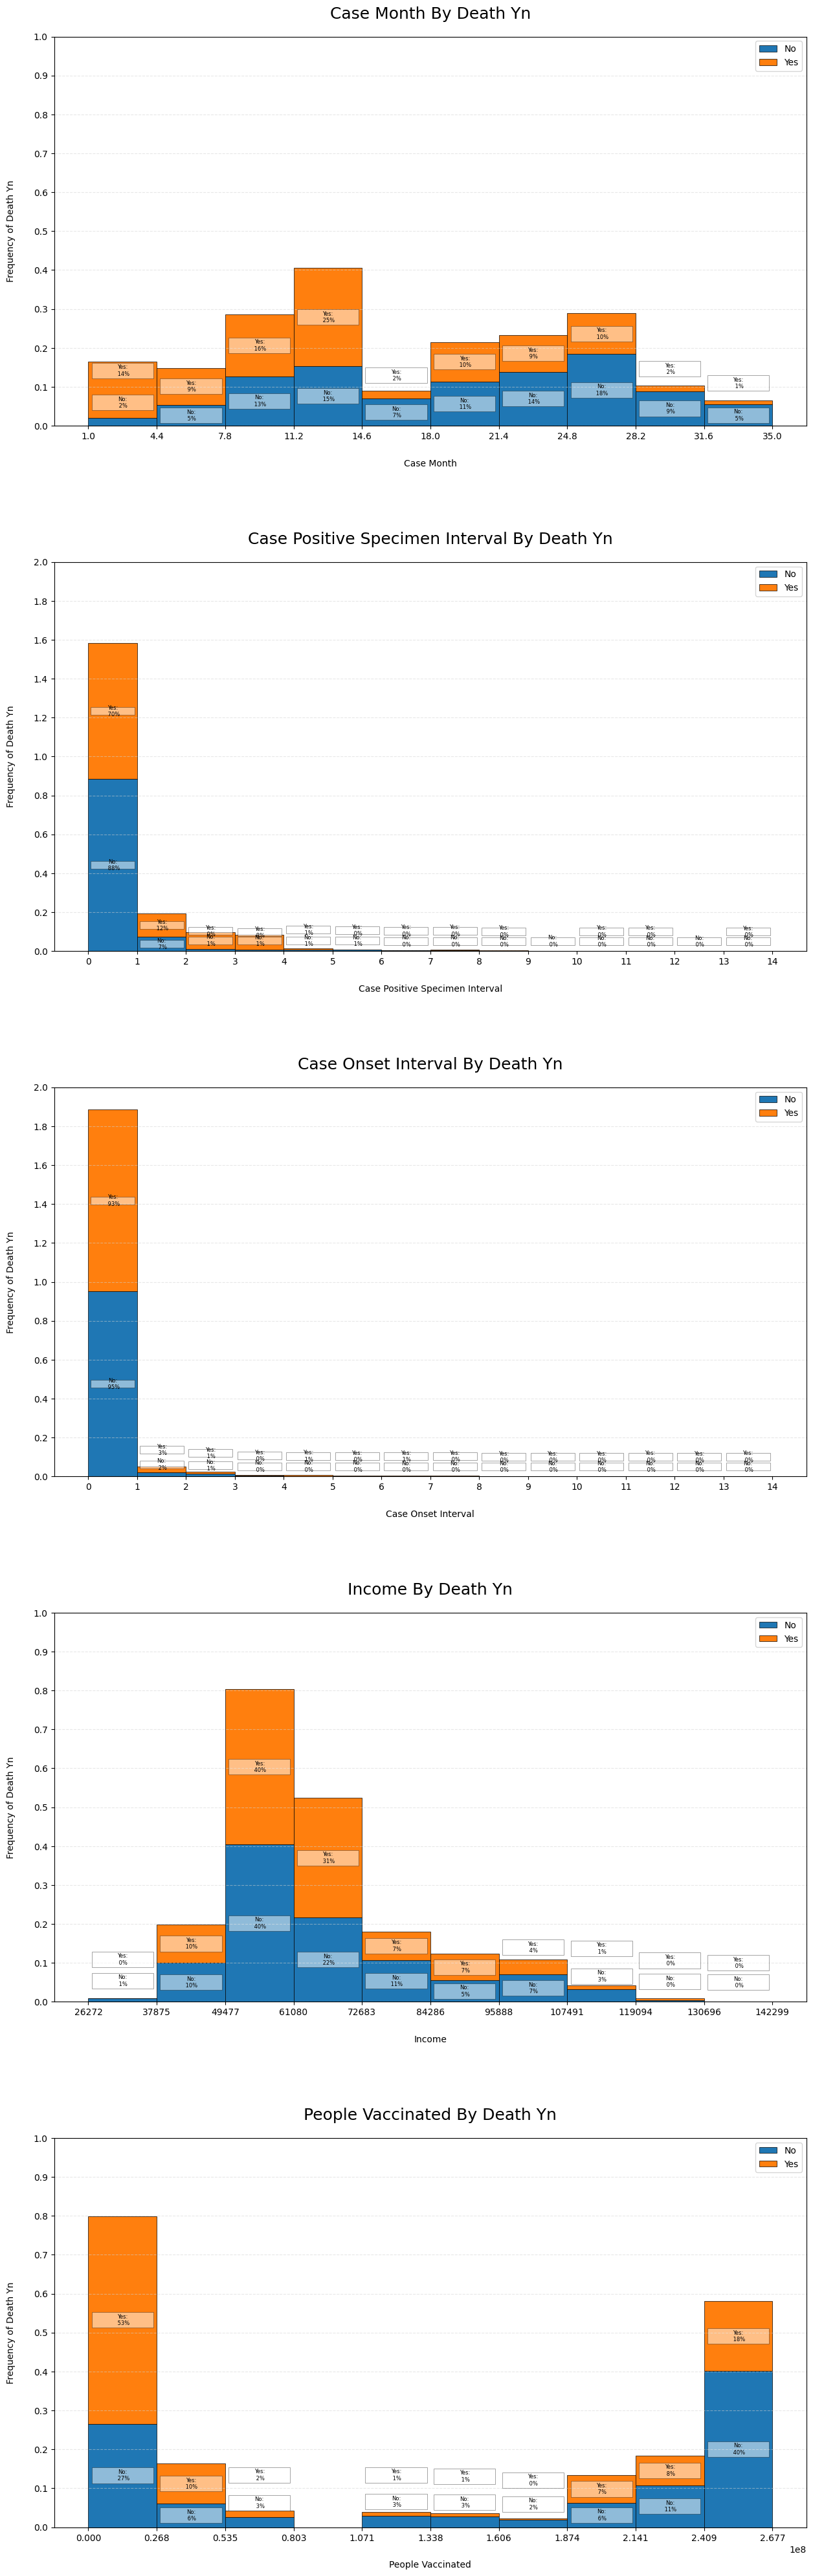

In [10]:
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(15,50))
fig.subplots_adjust(hspace=0.35)

for i, column in enumerate(continuous):
    if column == 'case_positive_specimen_interval' or column == 'case_onset_interval':
        createStackedHistograms(data_training, 'death_yn', column, bin_count = 14, ax=axs[i], filterExp=lambda row: row[column] <= 14, ylim=2)
    else:
        createStackedHistograms(data_training, 'death_yn', column, bin_count = 10, ax=axs[i])

#### **Selection of Indicative Continuous Features**
The set of indicative continuous features we will be using includes the following:
* case_positive_specimen_interval
* income
* case_month

The selection is based on both the information revealed in the frequency histograms and the correlation statistics from above. We have elected to eliminate the 'case_onset_interval' columns because of the overwhelming majority of values that result in 0 for this columns, and the even distribution of deaths (Yes and No within 1% of each other) for each value of this attribute. On the other hand, we have elected to keep 'case_positive_specimen_interval', since even though the overwhelming majority of values is 0, there is a correlation between deaths and the value. When the 'case_positive_specimen_interval' value is 0, the amount of deaths vs survivors is 70% vs 88%. For the next 4 values, these percentages flip, and the amount of deaths vs survivors is 12% vs 7%, 9% vs 1%, and 8% vs 1%.  
Income is another value we will keep (at least for now) because although there does seem to be a slight correlation between this number and death, and there is a nice distribution of data that may start to lead some interesting results.
Lastly, we will include case_month since there are clear trends between this value and the amount of deaths: i.e. earlier on there were more deaths, and later on there were less deaths. We have chosen to keep this column and eliminate the people_vaccinated column because there is a large correlation (94%) between the 2 columns, and case_month can capture other factors, like seasonal changes in the impact of the virus, the contagiousness of the virus, as well as the deadliness of the prevalent variant of the virus.

***
### Categorical Features
***

#### **Categorical - Categorical Plots**
<li style="color: blue; font-style: italic">Plot the correlations between all the categorical features (if any). Discuss what you observe in these plots.  </li>

#### **Categorical - Target Plots**
<li style="color: blue; font-style: italic">For each categorical feature, plot its pairwise interaction with the target feature. Discuss what  knowledge you gain from these plots, e.g., which categorical features seem to be better at predicting the target feature? </li>

#### **Selection of Indicative Categorical Features**
 <li style="color: blue; font-style: italic"> Choose a subset of categorical features you find promising (if any). Justify your choices. </li>

# **3.0 Predictive Modeling: Linear Regression** 

## 3.1 Train the Linear Regression Model
<span style="color: blue; font-style:italic;">On the training set, train a linear regression model to predict the target feature, using only the  descriptive features selected in exercise (1) above. </span>

## 3.2 Interpret the Linear Regression Model

### **Coefficients**
<span style="color: blue; font-style: italic;">  Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature).  </span>

### **Target Feature Values and Predicted Class**
<span style="color: blue; font-style: italic;">  Print the predicted target feature value for the first 10 training examples. Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. Print the predicted class for the first 10 examples.</span>

### **Classification Evaluation Measures on Training Set**
<span style="color: blue; font-style: italic;">   Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1)</span>

### **Running Analysis**
<span style="color: blue; font-style: italic"> discuss your findings so far. </span>

## 3.3 Evaluate the Linear Regression Model

### **Classification Evaluation Measures on the Testing Set**
<span style="color: blue; font-style: italic"> Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. </span>

### **Classification Evaluation Measures on Cross-Validated Set**
<span style="color: blue; font-style: italic"> Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. </span>

### **Running Analysis**
<span style="color: blue; font-style: italic"> Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings. </span>

# **4.0 Predictive Modeling: Logistic Regression** 

## 4.1 Train the Logistic Regression Model
<span style="color: blue; font-style:italic;">On the training set, train a logistic regression model to predict the target feature, using only the  descriptive features selected in exercise (1) above. </span>

## 4.2 Interpret the Logistic Regression Model

### **Coefficients**
<span style="color: blue; font-style: italic;">  Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature).  </span>

### **Target Feature Values and Predicted Class**
<span style="color: blue; font-style: italic;">  Print the predicted target feature value for the first 10 training examples. Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. Print the predicted class for the first 10 examples.</span>

### **Classification Evaluation Measures on Training Set**
<span style="color: blue; font-style: italic;">   Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1)</span>

### **Running Analysis**
<span style="color: blue; font-style: italic"> discuss your findings so far. </span>

## 4.3 Evaluate the Logistic Regression Model

### **Classification Evaluation Measures on the Testing Set**
<span style="color: blue; font-style: italic"> Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. </span>

### **Classification Evaluation Measures on Cross-Validated Set**
<span style="color: blue; font-style: italic"> Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. </span>

### **Running Analysis**
<span style="color: blue; font-style: italic"> Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings. </span>

# **5.0 Predictive Modeling: Random Forest** 

## 5.1 Train the Random Forest Model
<span style="color: blue; font-style:italic;">On the training set, train a random forest model to predict the target feature, using only the  descriptive features selected in exercise (1) above. </span>

## 5.2 Interpret the Random Forest Model

### **Coefficients**
<span style="color: blue; font-style: italic;">  Can you interpret the random forest model? Discuss any knowledge you can gain in regard of the working of this model.     </span>

### **Target Feature Values and Predicted Class**
<span style="color: blue; font-style: italic;">  Print the predicted target feature value for the first 10 training examples. Print the predicted class for the first 10 examples.</span>

### **Classification Evaluation Measures on Training Set**
<span style="color: blue; font-style: italic;">   Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1)</span>

### **Running Analysis**
<span style="color: blue; font-style: italic"> discuss your findings so far. </span>

## 5.3 Evaluate the Random Forest Model

### **Classification Evaluation Measures on the Testing Set**
<span style="color: blue; font-style: italic"> Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. </span>

### **Classification Evaluation Measures on Cross-Validated Set**
<span style="color: blue; font-style: italic"> Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. </span>

### **Running Analysis**
<span style="color: blue; font-style: italic"> Compare the cross-validation metrics to those obtained on the single train/test split and to the Random Forest out-of-sample error and discuss your findings. </span>

# **6.0 Conclusions**

<ul style="color:blue; font-style: italic;">
<li> Which model of the ones trained above performs better at predicting the target feature? Is it more accurate than a simple model that always predicts the majority class (i.e., if 'no' is the majority class in your dataset, the simple model always predicts 'no' for the target feature)? Justify your answers. </li>
<li> Summarise your understanding of the problem and of your predictive modeling results so far. Can you think of any new ideas to improve the best model so far (e.g., by using further data prep such as: feature selection, feature re-scaling, creating new features, combining predictive models, or using other domain knowledge)? Please show how your ideas actually work in practice (with code), by training and evaluating your proposed models. Summarise your findings so far. </li></ul>